## Misclassification cost as part of training

There are 2 ways in which we can introduce cost into the learning function of the algorithm with Scikit-learn:

- Defining the **class_weight** parameter for those estimators that allow it, when we set the estimator
- Passing a **sample_weight** vector with the weights for every single observation, when we fit the estimator.


With both the **class_weight** parameter or the **sample_weight** vector, we indicate that the loss function should be modified to accommodate the class imbalance and the cost attributed to each misclassification.

## parameters

**class_weight**: can take 'balanced' as argument, in which case it will use the balance ratio as weight. Alternatively, it can take a dictionary with {class: penalty}, pairs. In this case, it penalizes mistakes in samples of class[i] with class_weight[i].

So if class_weight = {0:1, and 1:10}, misclassification of observations of class 1 are penalized 10 times more than misclassification of observations of class 0.

**sample_weight** is a vector of the same length as y, containing the weight or penalty for each individual observation. In principle, it is more flexible, because it allows us to set weights to the observations and not to the class as a whole. So in this case, for example we could set up higher penalties for fraudulent applications that are more costly (money-wise)than to those fraudulent applications that are of little money.

## Important

If you use both class_weight and sample_weight, the final penalty will be **the combination of the 2**, so be very careful

## Demo

In this demo, I will introduce cost-sensitive learning to Logistic Regression. But keep in mind that you can do the same with almost every other classifier in Scikit-learn using **sample_weight** or, using **Class_weight** in those estimators that have that attribute.

## Classifiers that support class_weight

In [1]:
import sklearn
sklearn.__version__

'1.2.2'

In [2]:
# NOTE, THIS CELL WILL NOT WORK WITH SKLEARN VERSION > 0.24
# JUST COMMENT IT OUT, OR DELETE THIS CELL TO CARRY ON WITH THE NOTEBOOK.

# Let's find out which classifiers from sklearn support class_weight
# as part of the __init__ method, that is, when we set the m up

from sklearn.utils import all_estimators

estimators = all_estimators(type_filter='classifier')

for name, class_ in estimators:
    try:
        if hasattr(class_(), 'class_weight'):
            print(name)
    except:
        pass

DecisionTreeClassifier
ExtraTreeClassifier
ExtraTreesClassifier
HistGradientBoostingClassifier
LinearSVC
LogisticRegression
LogisticRegressionCV
NuSVC
PassiveAggressiveClassifier
Perceptron
RandomForestClassifier
RidgeClassifier
RidgeClassifierCV
SGDClassifier
SVC


Not all classifiers support class_weight. For those which don't, like GradientBoostingClassifier, we can still use sample_weight when we fit the estimator.

## Demo

In this demo, we are going to introduce the misclassification cost in Logistic Regression, using class_weight and then sample_weight.

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn import metrics  # omd
from sklearn.model_selection import train_test_split

In [4]:
# load data
# only a few observations to speed the computaton

# data = pd.read_csv('../kdd2004.csv').sample(10000)
data = pd.read_csv('../kdd2004.csv')

data.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,target
0,52.0,32.69,0.30,2.5,20.0,1256.8,-0.89,0.33,11.0,-55.0,...,1595.1,-1.64,2.83,-2.0,-50.0,445.2,-0.35,0.26,0.76,-1
1,58.0,33.33,0.00,16.5,9.5,608.1,0.50,0.07,20.5,-52.5,...,762.9,0.29,0.82,-3.0,-35.0,140.3,1.16,0.39,0.73,-1
2,77.0,27.27,-0.91,6.0,58.5,1623.6,-1.40,0.02,-6.5,-48.0,...,1491.8,0.32,-1.29,0.0,-34.0,658.2,-0.76,0.26,0.24,-1
3,41.0,27.91,-0.35,3.0,46.0,1921.6,-1.36,-0.47,-32.0,-51.5,...,2047.7,-0.98,1.53,0.0,-49.0,554.2,-0.83,0.39,0.73,-1
4,50.0,28.00,-1.32,-9.0,12.0,464.8,0.88,0.19,8.0,-51.5,...,479.5,0.68,-0.59,2.0,-36.0,-6.9,2.02,0.14,-0.23,-1


In [5]:
# imbalanced target

data.target.value_counts() / len(data)

-1    0.991108
 1    0.008892
Name: target, dtype: float64

In [6]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),  # drop the target
    data['target'],  # just the target
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((102025, 74), (43726, 74))

## Using class_weight

In [7]:
# Logistic Regression with class_weight

# we initialize the cost / weights when we set up the transformer

def run_Logit(X_train, X_test, y_train, y_test, class_weight):
    
    # weights introduced here
    logit = LogisticRegression(
        penalty='l2',
        solver='newton-cg',
        random_state=0,
        max_iter=10,
        n_jobs=4,
        class_weight=class_weight # weights / cost
    )
    
    logit.fit(X_train, y_train)

    print('Train set')
    pred = logit.predict_proba(X_train)
    print(
        'Logistic Regression ROC AUC: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = logit.predict_proba(X_test)
    print(
        'Logistic Regression ROC AUC: {}'.format(roc_auc_score(y_test, pred[:, 1])))
    preds = logit.predict(X_test)
    print(f"Logistic Regression Precision: {metrics.precision_score(y_test, preds)}")
    print(f"Logistic Regression Recall: {metrics.recall_score(y_test, preds)}")
    print(f"Logistic Regression F1: {metrics.f1_score(y_test, preds)}")

In [8]:
# evaluate performance of algorithm built
# using imbalanced dataset

run_Logit(X_train,
          X_test,
          y_train,
          y_test,
          class_weight=None)

Train set
Logistic Regression ROC AUC: 0.9230210002189093
Test set
Logistic Regression ROC AUC: 0.9256916712192443
Logistic Regression Precision: 0.9823788546255506
Logistic Regression Recall: 0.5506172839506173
Logistic Regression F1: 0.7056962025316456


/Users/oliverdreger/opt/anaconda3/envs/ml2023/lib/python3.11/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [9]:
# omd 

def performance(X, y, model, title=None):

    # Predict probabilities on the test set
    y_probs = model.predict_proba(X)[:, 1]
    y_preds = model.predict(X)

    # Calculate evaluation metrics
    roc_auc = metrics.roc_auc_score(y, y_probs)
    precision = metrics.precision_score(y, y_preds)
    recall = metrics.recall_score(y, y_preds)
    f1 = metrics.f1_score(y, y_preds)
    aupr = metrics.average_precision_score(y, y_probs)

    if title is None:
        title = 'Performance metrics:'
    else:
        title = f'Performance metrics: {title}'
    print(title)
    print("ROC AUC:".ljust(10) + f"{roc_auc:.2%}".rjust(8))
    print("Precision:".ljust(10) + f"{precision:.2%}".rjust(8))
    print("Recall:".ljust(10) + f"{recall:.2%}".rjust(8))
    print("F1:".ljust(10) + f"{f1:.2%}".rjust(8))
    print("AUPRC:".ljust(10) + f"{aupr:.2%}".rjust(8))
    print()

## Question: In the following code, how is the X_test and y_test_mod used in the xgb.fit() method? 

In the `xgb.fit()` method, `X_test` and `y_test_mod` are used as part of the `eval_set` parameter. The `eval_set` is a list of pairs, where each pair is a set of examples that will be used for validation during training. In this case, two pairs are provided: the training set `(X_train, y_train_mod)` and the test set `(X_test, y_test_mod)`.

The `eval_metric` parameter specifies the evaluation metric to be used on the validation set. Here, `f1_eval` is used, which likely refers to the F1 score, a common metric for binary classification problems.

The `early_stopping_rounds` parameter is used to stop training when the performance on the validation set doesn't improve for a specified number of rounds. In this case, if the F1 score doesn't improve for 10 rounds, training will stop early.

So, `X_test` and `y_test_mod` are used to monitor the model's performance on an unseen dataset during training, and to potentially stop training early if the model isn't improving. This can help prevent overfitting to the training data.  

## Question: So is there data leakage for the model's performance on forecasting X_test?  

No, there is no data leakage in this case. Data leakage would occur if information from the test set, `X_test`, was used during the training of the model. However, in this case, `X_test` and `y_test_mod` are only used for validation purposes during training, not for the actual training itself.

The model is trained on `X_train` and `y_train_mod`, and then its performance is evaluated on `X_test` and `y_test_mod`. This is a common practice in machine learning to assess how well the model generalizes to unseen data.

However, it's important to note that if you use the test set for tuning hyperparameters or making decisions about the model based on its performance on the test set, then it could lead to a form of data leakage known as "test set overuse". This is because you're using the test set to make decisions during the model development process, which should ideally only be done using the training and validation sets. The test set should ideally only be used once, at the very end of your modeling process, to evaluate final model performance. But in the provided code, there's no evidence of such misuse. So, there's no data leakage in this context.

## Question: Would the following code be appropriate to calculate the class weight and sample weight?

```python
class_weights = len(y_train) / y_train.value_counts()
sample_weights = np.array([class_weights[y] for y in y_train])
```
**Yes, the code you provided is appropriate** for calculating both the class weights and sample weights based on the distribution of classes in the training set. Let me break down what each line does:

```python
class_weights = len(y_train) / y_train.value_counts()
```
This line calculates the class weights. `y_train.value_counts()` returns the count of each unique class label in `y_train`, and `len(y_train)` is the total number of samples in the training set. By dividing the total number of samples by the count of each class, you're essentially calculating the inverse of the class frequencies. This will give higher weights to less frequent classes and lower weights to more frequent classes.

```python
sample_weights = np.array([class_weights[y] for y in y_train])
```
This line calculates the sample weights based on the class weights. For each sample label `y` in `y_train`, it retrieves the corresponding class weight from the `class_weights` dictionary and assigns it to the sample weight for that sample. This way, each sample is assigned a weight based on the class it belongs to.

Overall, this approach is suitable for assigning weights to address class imbalance in the training set. Just make sure to use these weights appropriately when training your model, as shown in the previous examples.


In [17]:
# omd 

from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.metrics import f1_score

imbal_ratio = len(y_train[y_train==-1]) // len(y_train[y_train==1])
print(f"Imbalance ratio: {imbal_ratio}")

def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1 - f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

params = {
    'learning_rate': 0.1,
    'n_estimators': 100,
    'max_depth': 12,
    'scale_pos_weight': imbal_ratio,
    # 'max_delta_step': 10,
    'reg_alpha':0.5,
    'reg_lambda':0.5,
    # 'subsample': 0.9,
    # 'colsample_bytree': 0.5
}

# xgb = XGBClassifier(**params, n_jobs=-1, random_state=0)
xgb = XGBClassifier(n_jobs=-1, random_state=0)
# xgb = XGBRFClassifier(**params, n_jobs=-1, random_state=0)

y_train_mod = y_train.replace(-1, 0)
y_test_mod = y_test.replace(-1, 0)

# Calculate class_weights and sample_weights based on the class_weights
class_weights = len(y_train) / y_train_mod.value_counts()
sample_weights = np.array([class_weights[y] for y in y_train_mod])

xgb.fit(X_train, y_train_mod, sample_weight=sample_weights, 
        eval_set=[(X_train, y_train_mod), (X_test, y_test_mod)], eval_metric=f1_eval, 
        early_stopping_rounds=10, verbose=True)

# Calculate performance metrics
roc_auc_train = roc_auc_score(y_train_mod, xgb.predict_proba(X_train)[:,1])
print(f'ROC AUC for X_train: {roc_auc_train:.2%}')

# Show model performance for X_test 
performance(X_test, y_test_mod, xgb, title="X_test")

Imbalance ratio: 113


/Users/oliverdreger/opt/anaconda3/envs/ml2023/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/oliverdreger/opt/anaconda3/envs/ml2023/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.47240	validation_0-f1_err:0.72264	validation_1-logloss:0.47316	validation_1-f1_err:0.72488
[1]	validation_0-logloss:0.34251	validation_0-f1_err:0.57021	validation_1-logloss:0.34442	validation_1-f1_err:0.61077
[2]	validation_0-logloss:0.25595	validation_0-f1_err:0.55065	validation_1-logloss:0.25820	validation_1-f1_err:0.58770
[3]	validation_0-logloss:0.19627	validation_0-f1_err:0.44729	validation_1-logloss:0.19929	validation_1-f1_err:0.49718
[4]	validation_0-logloss:0.15439	validation_0-f1_err:0.42736	validation_1-logloss:0.15748	validation_1-f1_err:0.48543
[5]	validation_0-logloss:0.12324	validation_0-f1_err:0.40061	validation_1-logloss:0.12694	validation_1-f1_err:0.45509
[6]	validation_0-logloss:0.10104	validation_0-f1_err:0.39145	validation_1-logloss:0.10478	validation_1-f1_err:0.44207
[7]	validation_0-logloss:0.08520	validation_0-f1_err:0.39646	validation_1-logloss:0.08914	validation_1-f1_err:0.45249
[8]	validation_0-logloss:0.07317	validation_0-f1_err:0.3

In [18]:
# omd

# Save the trained XGBoost model
xgb.save_model('xgb_model.json')

In [19]:
# omd

# Create a new XGBoost model
xgb_loaded = XGBClassifier(n_jobs=-1, random_state=0)

# Load the model from the file
xgb_loaded.load_model('xgb_model.json')

# Show model performance for X_test 
performance(X_test, y_test_mod, xgb_loaded, title="X_test")

Performance metrics: X_test
ROC AUC:    99.29%
Precision:  92.33%
Recall:     83.21%
F1:         87.53%
AUPRC:      90.91%



In [20]:
df_temp = pd.DataFrame({'y': y_train_mod, 'sample_weight': sample_weights})
display(df_temp[df_temp['y']==0].head())
display(df_temp[df_temp['y']==1].head())

,y,sample_weight
120222,0,1.00881
38087,0,1.00881
58290,0,1.00881
79865,0,1.00881
45816,0,1.00881


,y,sample_weight
111303,1,114.506173
43826,1,114.506173
94241,1,114.506173
43003,1,114.506173
142377,1,114.506173


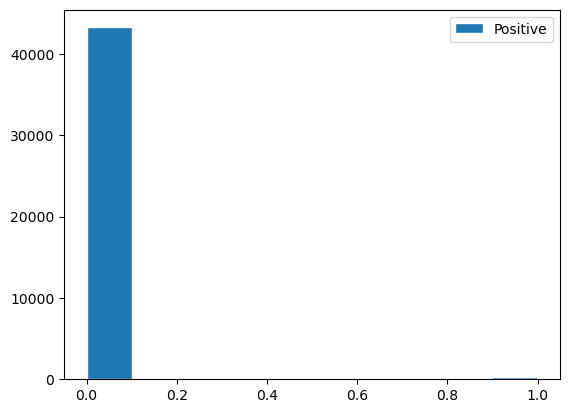

In [22]:
from matplotlib import pyplot as plt 

pred_proba = xgb_loaded.predict_proba(X_test)[:]
pred_proba = pd.DataFrame(pred_proba).round(6)
# plt.hist(pred_proba[0], bins=10, ec='white', label='Negative')
plt.hist(pred_proba[1], bins=10, ec='white', label='Positive')
plt.legend()
plt.show()

### <font color="green"> omd </font>
## Calibrating the output probabilities of an XGBoost model can be achieved through a few methods:

1. **Isotonic Regression**: This is a non-parametric method that can be used to transform the output probabilities to be more calibrated¹. Here's an example of how you might use it in Python:

```python
from sklearn.isotonic import IsotonicRegression

# Assume y_pred_train are your predicted probabilities from the training set
calibr = IsotonicRegression()
calibr.fit(y_pred_train, y_train)

# Now you can calibrate your test set predictions
y_pred_test_calibrated = calibr.predict(y_pred_test)
```

2. **Platt Scaling**: This method involves fitting a logistic regression model to the model's scores. This can be done using `CalibratedClassifierCV` in scikit-learn with `method='sigmoid'`². However, this method may not work well with unbalanced problems or non-linear relationships².

3. **Adjusting the `scale_pos_weight` parameter**: If you're dealing with imbalanced classes, the `scale_pos_weight` parameter in XGBoost can affect the calibration of your probabilities. You might want to experiment with different values for this parameter¹.

4. **Tuning other hyperparameters**: Other hyperparameters such as `max_depth`, `lambda`, and `subsample` can also affect the calibration of your probabilities⁴. You might want to experiment with these as well.

Remember, the best method for calibration can depend on your specific use case and data. It's often a good idea to try different methods and see which one works best for your situation. Also, always validate the calibration of your model using a separate validation set to avoid overfitting.

Source: Conversation with Bing, 3/24/2024
(1) Calibration curve of XGBoost for binary classification. https://stats.stackexchange.com/questions/417806/calibration-curve-of-xgboost-for-binary-classification.
(2) XGBoost: how to adjust the probabilities of a binary classifier to .... https://datascience.stackexchange.com/questions/67342/xgboost-how-to-adjust-the-probabilities-of-a-binary-classifier-to-match-trainin.
(3) XGBoost Classifier not capturing extreme probabilities. https://stats.stackexchange.com/questions/566392/xgboost-classifier-not-capturing-extreme-probabilities.
(4) classification - How to calibrate an XGBoost classifier which has been .... https://stats.stackexchange.com/questions/565244/how-to-calibrate-an-xgboost-classifier-which-has-been-trained-on-a-sampled-datas.
(5) XGBoost produce prediction result and probability. https://stackoverflow.com/questions/61082381/xgboost-produce-prediction-result-and-probability.

In [23]:
# omd

from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibratedClassifierCV

# Calibrate the XGBClassifier
calibrated = CalibratedClassifierCV(xgb_loaded, method='isotonic', cv=5)
calibrated.fit(X_train, y_train_mod, sample_weight=sample_weights)

# Now you can predict probabilities on the test set
probabilities = calibrated.predict_proba(X_test)

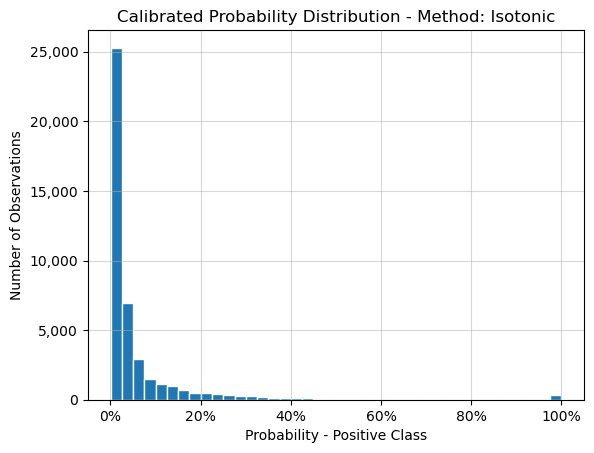

In [24]:
# omd
from matplotlib import ticker as mticker 

plt.hist(probabilities[:,1], bins=40, ec='white')
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.0%}'))
plt.title('Calibrated Probability Distribution - Method: Isotonic')
plt.ylabel('Number of Observations')
plt.xlabel('Probability - Positive Class')
plt.grid(True, alpha=0.5);

If you have trained an XGBoost classifier using sample weights to address class imbalance and you want to calibrate the predicted probabilities, you can use various calibration methods, such as Platt scaling or isotonic regression. These methods adjust the predicted probabilities to better reflect the true probability estimates.

Here's how you can perform Platt scaling using scikit-learn:

```python
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Assuming you have already trained an XGBoost classifier
# and have X_train, y_train, X_test, y_test

# Create a CalibratedClassifierCV instance
calibrated_clf = CalibratedClassifierCV(base_estimator=xgb.XGBClassifier(objective='binary:logistic'), method='sigmoid')

# Fit the calibrated classifier on the training data
calibrated_clf.fit(X_train, y_train, sample_weight=sample_weights)  # Assuming sample_weights are calculated

# Predict probabilities for the training data
calibrated_probs = calibrated_clf.predict_proba(X_train)[:, 1]

# Now calibrated_probs contains the calibrated probabilities
```

In this example:

1. We import `CalibratedClassifierCV` from scikit-learn.
2. We create an instance of `CalibratedClassifierCV` with the XGBoost classifier (`xgb.XGBClassifier`) as the base estimator and set the calibration method to `'sigmoid'`, which corresponds to Platt scaling.
3. We fit the calibrated classifier on the training data, including the sample weights if necessary.
4. We use the calibrated classifier to predict probabilities for the training data. The calibrated probabilities are stored in `calibrated_probs`.

After calibrating the probabilities, you can use them for further analysis or decision-making. Adjust the calibration method and parameters as needed for your specific problem and requirements.

### <font color="green">omd</font>

Calibrating the output of an XGBClassifier is not always necessary. The XGBoost algorithm, when used with the 'binary:logistic' objective function, should theoretically produce well-calibrated probabilities¹. However, there are certain situations where calibration might be beneficial or detrimental:

1. **Imbalanced Classes**: If you're dealing with imbalanced classes, the `scale_pos_weight` parameter in XGBoost can affect the calibration of your model. Setting `scale_pos_weight` to a value other than 1 might skew your probabilities higher than the data would suggest¹.

2. **Calibration Method**: The method used for calibration can also impact the results. For instance, using Platt scaling (method='sigmoid') with gradient boosting might not be the best choice, as gradient boosting tends to push probability toward 0 and 1¹. An alternative could be to try method='isotonic'¹.

3. **Model Performance**: Calibration can sometimes negatively impact the performance of your model. For example, one user reported that after calibrating their XGBClassifier, the outputted probabilities were clipped at ~0.75¹.

In conclusion, whether or not to calibrate your XGBClassifier depends on your specific use case and the characteristics of your data. It's recommended to experiment with different settings and evaluate the performance of your model accordingly. Always remember to validate your model using a separate test set or cross-validation to ensure its generalizability.

Source: Conversation with Bing, 3/30/2024
(1) Calibration curve of XGBoost for binary classification. https://stats.stackexchange.com/questions/417806/calibration-curve-of-xgboost-for-binary-classification.
(2) How to Configure XGBoost for Imbalanced Classification. https://machinelearningmastery.com/xgboost-for-imbalanced-classification/.
(3) How to use CalibratedClassifierCV on already trained xgboost model?. https://stackoverflow.com/questions/61508945/how-to-use-calibratedclassifiercv-on-already-trained-xgboost-model.
(4) scikit learn - TypeError with Sklear XGBoost and Sklearn Calibrated .... https://stackoverflow.com/questions/66333573/typeerror-with-sklear-xgboost-and-sklearn-calibrated-classifier-cv.
(5) Multiclass classification with xgboost classifier? - Stack Overflow. https://stackoverflow.com/questions/57986259/multiclass-classification-with-xgboost-classifier.

In [194]:
# evaluate performance of algorithm built
# cost estimated as imbalance ratio

# 'balanced' indicates that we want same amount of 
# each observation, thus, imbalance ratio

run_Logit(X_train,
          X_test,
          y_train,
          y_test,
          class_weight='balanced')

Train set
Logistic Regression ROC AUC: 0.9729997074477335
Test set
Logistic Regression ROC AUC: 0.972824915125416
Logistic Regression Precision: 0.1343054489639294
Logistic Regression Recall: 0.8641975308641975
Logistic Regression F1: 0.23248090335436733


/Users/oliverdreger/opt/anaconda3/envs/ml2023/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [25]:
# evaluate performance of algorithm built
# cost estimated as imbalance ratio

# alternatively, we can pass a different cost
# in a dictionary, if we know it already

run_Logit(X_train,
          X_test,
          y_train,
          y_test,
          class_weight={-1:1, 1:10})

Train set
Logistic Regression ROC AUC: 0.957229739778965
Test set
Logistic Regression ROC AUC: 0.9566074218844622
Logistic Regression Precision: 0.6902439024390243
Logistic Regression Recall: 0.6987654320987654
Logistic Regression F1: 0.694478527607362


/Users/oliverdreger/opt/anaconda3/envs/ml2023/lib/python3.11/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


Play with the cost and see what you get in terms of performance.

## Using sample_weight

In [26]:
# Logistic Regression + sample_weight

# we pass the weights / cost, when we train the algorithm

def run_Logit(X_train, X_test, y_train, y_test, sample_weight):
    
    logit = LogisticRegression(
        penalty='l2',
        solver='newton-cg',
        random_state=0,
        max_iter=10,
        n_jobs=4,
    )
    
    # costs are passed here
    logit.fit(X_train, y_train, sample_weight=sample_weight)

    print('Train set')
    pred = logit.predict_proba(X_train)
    print(
        'Logistic Regression ROC AUC: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = logit.predict_proba(X_test)
    print(
        'Logistic Regression ROC AUC: {}'.format(roc_auc_score(y_test, pred[:, 1])))
    preds = logit.predict(X_test)
    print(f"Logistic Regression Precision: {metrics.precision_score(y_test, preds)}")
    print(f"Logistic Regression Recall: {metrics.recall_score(y_test, preds)}")
    print(f"Logistic Regression F1: {metrics.f1_score(y_test, preds)}")

In [27]:
# evaluate performance of algorithm built
# using imbalanced dataset

run_Logit(X_train,
          X_test,
          y_train,
          y_test,
          sample_weight=None)

Train set
Logistic Regression ROC AUC: 0.9230210002189093
Test set
Logistic Regression ROC AUC: 0.9256916712192443
Logistic Regression Precision: 0.9823788546255506
Logistic Regression Recall: 0.5506172839506173
Logistic Regression F1: 0.7056962025316456


/Users/oliverdreger/opt/anaconda3/envs/ml2023/lib/python3.11/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [28]:
# evaluate performance of algorithm built
# cost estimated as imbalance ratio

# with numpy.where, we introduce a cost of 99 to
# each observation of the minority class, and 1
# otherwise.

run_Logit(X_train,
          X_test,
          y_train,
          y_test,
          sample_weight=np.where(y_train==1,99,1))

Train set
Logistic Regression ROC AUC: 0.9752757045985172
Test set
Logistic Regression ROC AUC: 0.9753327514013247
Logistic Regression Precision: 0.1328358208955224
Logistic Regression Recall: 0.8790123456790123
Logistic Regression F1: 0.23079416531604538


/Users/oliverdreger/opt/anaconda3/envs/ml2023/lib/python3.11/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


## Conclusion

Cost-sensitive learning has improved the performance of the model.

**HOMEWORK**

Try other machine learning algorithms and other datasets available in imbalanced-learn